
# 1. Problem Statement

- Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks. 

 

- As expected, store sales are influenced by many factors, including promotional campaigns, competition, state holidays, seasonality, and locality.

 

- With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied. To overcome this problem, the company has hired you as a data scientist to work on the forecasting problem. As part of your job role, you are tasked with building a forecasting model to forecast the daily sales for the next six weeks. To help you with the same, you have been provided with historical sales data for 1,115 Rossmann stores.

# 2. Data Defination

1. Store - a unique Id for each store
2. DayOfWeek - Describes the day of the week (1 - Monday till 7 - Sunday)
3. Date - Describes the date on the day
4. Sales - the turnover for any given day (this is what you are forecasting)
5. Customers - the number of customers on a given day
6. Open - an indicator for whether the store was open: 0 = closed, 1 = open
7. StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
8. SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
9. Store - an Id that represents the store
10. StoreType - differentiates between 4 different store models: a, b, c, d
11. Assortment - describes an assortment level: a = basic, b = extra, c = extended
12. CompetitionDistance - describes thedistance in meters to the nearest competitor store
13. CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
14. Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
15. Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
16. PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb, May, Aug, Nov" means each round starts in February, May, August, November of any given year for that store

# 3. Importing required libraries and Dataset

In [1]:
# importing library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pylab
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import plotly.express as px

from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
# Graph Theme
sns.set_style('dark')

In [3]:
# import warnings

import warnings
warnings.filterwarnings('ignore')

#### Adding train Dataset

In [4]:
# importing training dataset
data = pd.read_csv('train_cap.csv')

# top 5 records
data.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [5]:
# shape of dataset
data.shape

(1017209, 9)

In [6]:
# datatype of each variable
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


#### Adding Store Dataset

In [7]:
# Importing Store dataset
store = pd.read_csv('store.csv')

# top 5 records
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [8]:
# shape of dataset
store.shape

(1115, 10)

In [9]:
# datatype of each variable
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


#### Merging above dataset

In [10]:
# Merging two dataframes
mdata = pd.merge(data,store, on= 'Store' )

# top 5 rows
mdata.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      1          4  2015-07-30   5020        546     1      1            0   
2      1          3  2015-07-29   4782        523     1      1            0   
3      1          2  2015-07-28   5011        560     1      1            0   
4      1          1  2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         c          a               1270.0   
2              1         c          a               1270.0   
3              1         c          a               1270.0   
4              1         c          a               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    2008.0       0   
2                        9.0                    2008.0       0   
3                        9.0                    2008.0       0   
4                        9.0                    2008.0       0   

   Promo2SinceWeek  Promo2SinceYear PromoInterval  
0              NaN              NaN           NaN  
1              NaN              NaN           NaN  
2              NaN              NaN           NaN  
3              NaN              NaN           NaN  
4              NaN              NaN           NaN

In [11]:
# bottom 5 rows
mdata.tail()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
1017204   1115          6  2013-01-05   4771        339     1      0   
1017205   1115          5  2013-01-04   4540        326     1      0   
1017206   1115          4  2013-01-03   4297        300     1      0   
1017207   1115          3  2013-01-02   3697        305     1      0   
1017208   1115          2  2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
1017204            0              1         d          c               5350.0   
1017205            0              1         d          c               5350.0   
1017206            0              1         d          c               5350.0   
1017207            0              1         d          c               5350.0   
1017208            a              1         d          c               5350.0   

         CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
1017204                        NaN                       NaN       1   
1017205                        NaN                       NaN       1   
1017206                        NaN                       NaN       1   
1017207                        NaN                       NaN       1   
1017208                        NaN                       NaN       1   

         Promo2SinceWeek  Promo2SinceYear     PromoInterval  
1017204             22.0           2012.0  Mar,Jun,Sept,Dec  
1017205             22.0           2012.0  Mar,Jun,Sept,Dec  
1017206             22.0           2012.0  Mar,Jun,Sept,Dec  
1017207             22.0           2012.0  Mar,Jun,Sept,Dec  
1017208             22.0           2012.0  Mar,Jun,Sept,Dec

# 4. Data Cleaning/Preprocessing

#### Creating New variable

In [12]:
# converting the Date variable into datetime function

mdata['Date'] = pd.to_datetime(mdata['Date'])

In [13]:
# creating new variable called Month, Year

mdata['Month'] =  mdata.Date.dt.month
mdata['Year'] =  mdata.Date.dt.year

In [14]:
# Creating new variable sales per customer for a day
mdata['SalePerCust'] = round(mdata['Sales']/mdata['Customers'], 1)

# Replacing NaN values with 0
mdata['SalePerCust'] = mdata['SalePerCust'].fillna(0)

#### Fixing column

In [15]:
# Checking the StateHoliday column

mdata.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [16]:
# replacing the 0 with '0'
mdata['StateHoliday'] = mdata['StateHoliday'].replace(0, '0')

mdata.StateHoliday.unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [17]:
# variables in StateHoliday 
mdata.StateHoliday.value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [18]:
# converting the StateHoliday into yes and No
mdata['IsStateHoliday'] =  mdata.StateHoliday.map({'0' : 0, 'a': 1, 'b': 1, 'c': 1})

#### Checking and Fixing null values

In [19]:
# checking for null values

mdata.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
Month                             0
Year                              0
SalePerCust                       0
IsStateHoliday                    0
dtype: int64

In [20]:
# replacing null values with 0

mdata['CompetitionDistance'] =mdata['CompetitionDistance'].fillna(0)
mdata['CompetitionOpenSinceMonth'] = mdata['CompetitionOpenSinceMonth'].fillna(0)
mdata['CompetitionOpenSinceYear'] = mdata['CompetitionOpenSinceYear'].fillna(0)
mdata['Promo2SinceWeek'] = mdata['Promo2SinceWeek'].fillna(0)
mdata['Promo2SinceYear'] = mdata['Promo2SinceYear'].fillna(0)
mdata['PromoInterval'] = mdata['PromoInterval'].fillna(0)

#### Statistics

In [21]:
# checking stat of numerical variable

mdata.describe(percentiles = [0.75,0.99])

Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
99%    1.104000e+03  7.000000e+00  1.716000e+04  2.267000e+03  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  SchoolHoliday  CompetitionDistance  \
count  1.017209e+06   1.017209e+06         1.017209e+06   
mean   3.815145e-01   1.786467e-01         5.415982e+03   
std    4.857586e-01   3.830564e-01         7.710253e+03   
min    0.000000e+00   0.000000e+00         0.000000e+00   
50%    0.000000e+00   0.000000e+00         2.320000e+03   
75%    1.000000e+00   0.000000e+00         6.880000e+03   
99%    1.000000e+00   1.000000e+00         3.641000e+04   
max    1.000000e+00   1.000000e+00         7.586000e+04   

       CompetitionOpenSinceMonth  CompetitionOpenSinceYear        Promo2  \
count               1.017209e+06              1.017209e+06  1.017209e+06   
mean                4.926878e+00              1.370173e+03  5.005638e-01   
std                 4.283543e+00              9.353634e+02  4.999999e-01   
min                 0.000000e+00              0.000000e+00  0.000000e+00   
50%                 4.000000e+00              2.006000e+03  1.000000e+00   
75%                 9.000000e+00              2.011000e+03  1.000000e+00   
99%                 1.200000e+01              2.015000e+03  1.000000e+00   
max                 1.200000e+01              2.015000e+03  1.000000e+00   

       Promo2SinceWeek  Promo2SinceYear         Month          Year  \
count     1.017209e+06     1.017209e+06  1.017209e+06  1.017209e+06   
mean      1.164767e+01     1.007011e+03  5.846762e+00  2.013832e+03   
std       1.532393e+01     1.005877e+03  3.326097e+00  7.773960e-01   
min       0.000000e+00     0.000000e+00  1.000000e+00  2.013000e+03   
50%       1.000000e+00     2.009000e+03  6.000000e+00  2.014000e+03   
75%       2.200000e+01     2.012000e+03  8.000000e+00  2.014000e+03   
99%       4.500000e+01     2.014000e+03  1.200000e+01  2.015000e+03   
max       5.000000e+01     2.015000e+03  1.200000e+01  2.015000e+03   

        SalePerCust  IsStateHoliday  
count  1.017209e+06    1.017209e+06  
mean   7.880226e+00    3.052470e-02  
std    4.089352e+00    1.720261e-01  
min    0.000000e+00    0.000000e+00  
50%    8.700000e+00    0.000000e+00  
75%    1.050000e+01    0.000000e+00  
99%    1.500000e+01    1.000000e+00  
max    6.500000e+01    1.000000e+00

#### Variable count in each category

In [22]:
# taking out all the variables
var = mdata.columns

for i in var.drop(['Date','Sales','Customers']):
    print('*'*15, i, '*'*15,)
    print(mdata[i].value_counts())
    print()

*************** Store ***************
1      942
726    942
708    942
709    942
713    942
      ... 
159    758
637    758
636    758
633    758
155    758
Name: Store, Length: 1115, dtype: int64

*************** DayOfWeek ***************
5    145845
4    145845
3    145665
2    145664
1    144730
7    144730
6    144730
Name: DayOfWeek, dtype: int64

*************** Open ***************
1    844392
0    172817
Name: Open, dtype: int64

*************** Promo ***************
0    629129
1    388080
Name: Promo, dtype: int64

*************** StateHoliday ***************
0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

*************** SchoolHoliday ***************
0    835488
1    181721
Name: SchoolHoliday, dtype: int64

*************** StoreType ***************
a    551627
d    312912
c    136840
b     15830
Name: StoreType, dtype: int64

*************** Assortment ***************
a    537445
c    471470
b      8294
Name: Assortment, dtype: int64

***

In [23]:
# total stores present in datasets

len(mdata.Store.unique())

1115

In [24]:
# start and end points in dataset
print(mdata.Date.min(), mdata.Date.max(), (mdata.Date.max() - mdata.Date.min()).days )

2013-01-01 00:00:00 2015-07-31 00:00:00 941


In [25]:
# store type with store
mdata.groupby('StoreType')['Store'].nunique()

StoreType
a    602
b     17
c    148
d    348
Name: Store, dtype: int64

In [26]:
# Assortment type with store
mdata.groupby('Assortment')['Store'].nunique()

Assortment
a    593
b      9
c    513
Name: Store, dtype: int64

#### Checking for the outlier and distribution

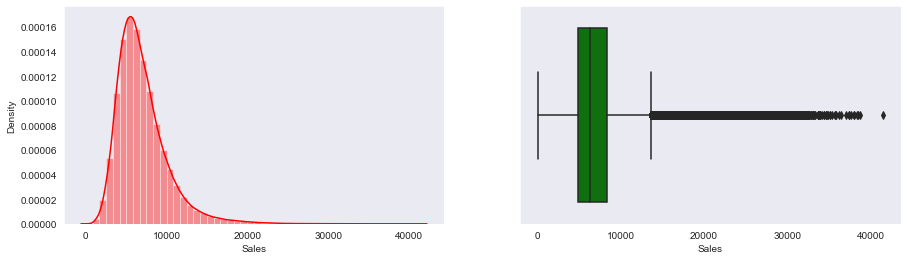

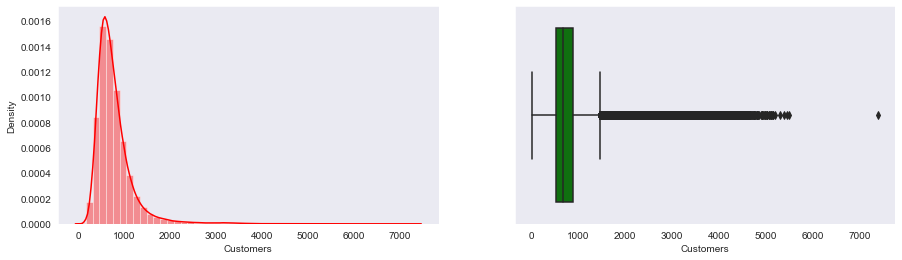

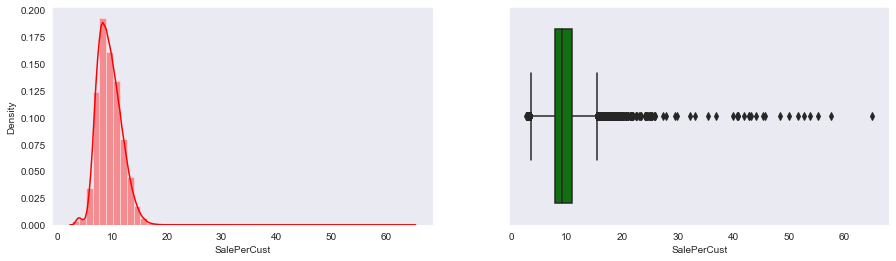

In [27]:
# taking out the variable
d= ['Sales', 'Customers', 'SalePerCust']

# plotting the distribution and box plot

for i in d:
    plt.figure(figsize=(15,4))
    plt.title(i)
    plt.subplot(1,2,1)
    sns.distplot(mdata[mdata['Sales'] != 0][i], color = 'red')
    plt.subplot(1,2,2)
    sns.boxplot(mdata[mdata['Sales'] != 0][i], color = 'green')

In [28]:
# outiler treatment

outlier_col = ["Sales", "Customers", "SalePerCust", "CompetitionDistance"]

for i in mdata[outlier_col]:
    Q3 = mdata[i].quantile(0.99)
    mdata.loc[mdata[i] > Q3, i] = Q3

**Inference**
- The given dataset contain of 1115 stores, and the data is between 1/1/2013 to 31/07/2015 i,e 941 days. 
- Dataset contain Open variable which indicates status of the store whether it is open or close.
- Dataset contain 20260 records for public holidays, 6690 records for Ester holidays and 4100 for chrismas holidays.
- Dataset is divided into 4 different store types a, b, c, d. In which 'a' store type have maximum stores which is 602 and b have lowes which is 17.
- the store is classified into 3 classes, class 'a' have maximum stores present which is 593 and class b have miminum 9.
- If we neglect the of days, then the 'Sales', 'Customers', 'SalePerCust' variables are right skewed variables indicating the outliers are present in dataset.   
- Outlier is due to the peak sales for store, and the peak is observed to be as seasonal in nature (Shown in later stages)

# 5. Exploratory Data Analysis

#### Temporal variation in each term

In [29]:
# group_by for the time component and feature variable

def groupby_var(var, time):
    gdf1 = mdata.groupby(time)[var].aggregate(['min','max','sum', 'mean']).round()
    gdf = mdata.groupby(time)[var].aggregate(['min','max','sum', 'mean']).round().reset_index()
    fig = plt.figure(figsize = (16,5))
    plt.subplot(1,2,1)
    plt.title('Sum')
    sns.barplot(data = gdf, x =time, y = 'sum')
    plt.subplot(1,2,2)
    plt.title('Mean')
    sns.barplot(data = gdf, x =time, y = 'mean')
    return gdf1

##### Sales Variable

min    max         sum    mean
DayOfWeek                                
1            0  17160  1118441897  7728.0
2            0  17160  1015363707  6971.0
3            0  17160   951733622  6534.0
4            0  17160   908047916  6226.0
5            0  17160   976765072  6697.0
6            0  17160   843764718  5830.0
7            0  17160    27749007   192.0

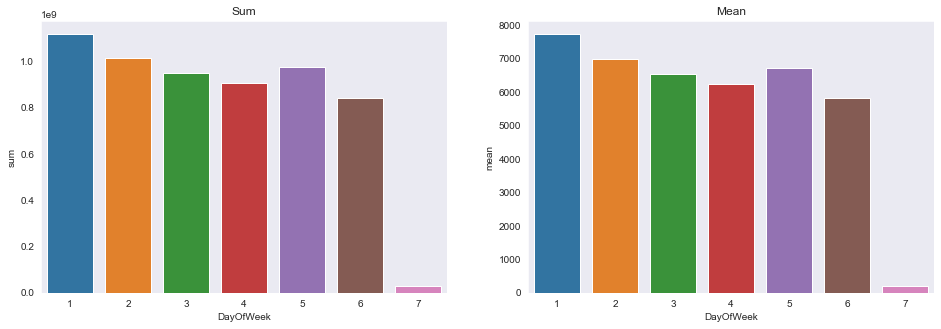

In [30]:
# sales and dayofweek variable 

groupby_var('Sales', 'DayOfWeek')

min    max        sum    mean
Month                               
1        0  17160  564993762  5449.0
2        0  17160  526766083  5624.0
3        0  17160  596751583  5755.0
4        0  17160  572837583  5708.0
5        0  17160  566271649  5461.0
6        0  17160  574655266  5727.0
7        0  17160  592510341  6039.0
8        0  17160  360527643  5673.0
9        0  17160  341378157  5551.0
10       0  17160  350632503  5517.0
11       0  17160  367821841  5981.0
12       0  17160  426719528  6715.0

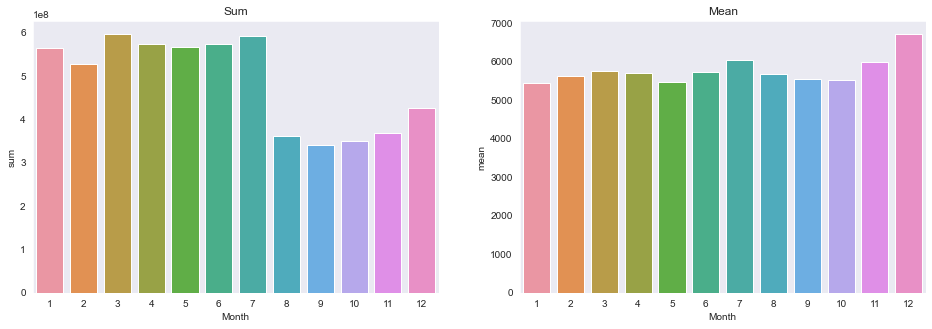

In [31]:
# sales and Month variable 

groupby_var('Sales', 'Month')

min    max         sum    mean
Year                                
2013    0  17160  2289699087  5626.0
2014    0  17160  2169191129  5802.0
2015    0  17160  1382975723  5851.0

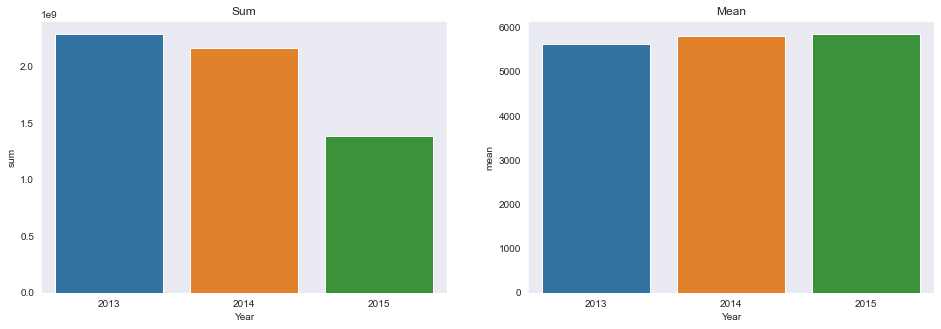

In [32]:
# sales and Year variable 

groupby_var('Sales', 'Year')

##### Customers

min   max        sum   mean
DayOfWeek                             
1            0  2267  116435805  805.0
2            0  2267  109877403  754.0
3            0  2267  104226773  716.0
4            0  2267  100793474  691.0
5            0  2267  107243951  735.0
6            0  2267   94244758  651.0
7            0  2267    4486516   31.0

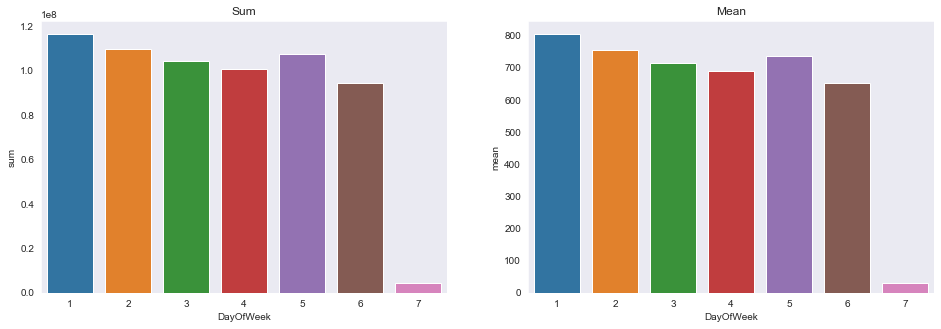

In [33]:
# Customers and dayofweek variable 

groupby_var('Customers', 'DayOfWeek')

min   max       sum   mean
Month                            
1        0  2267  61933937  597.0
2        0  2267  58183768  621.0
3        0  2267  64644352  623.0
4        0  2267  62596432  624.0
5        0  2267  61677776  595.0
6        0  2267  61985075  618.0
7        0  2267  63741173  650.0
8        0  2267  40428136  636.0
9        0  2267  38662491  629.0
10       0  2267  39694379  625.0
11       0  2267  39798776  647.0
12       0  2267  43962385  692.0

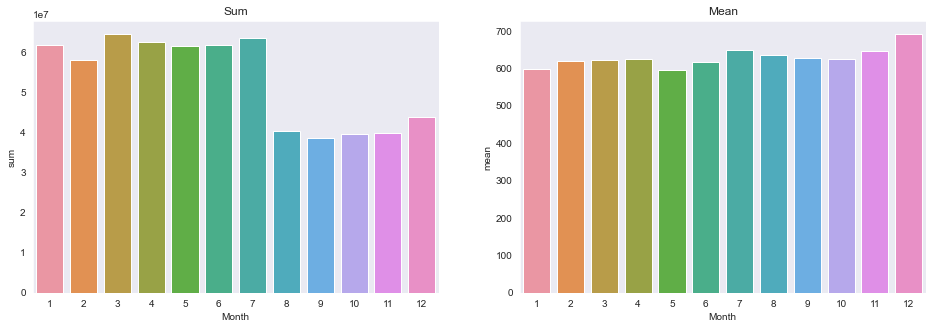

In [34]:
# Customers and Month variable 

groupby_var('Customers', 'Month')

min   max        sum   mean
Year                             
2013    0  2267  253433554  623.0
2014    0  2267  237820164  636.0
2015    0  2267  146054962  618.0

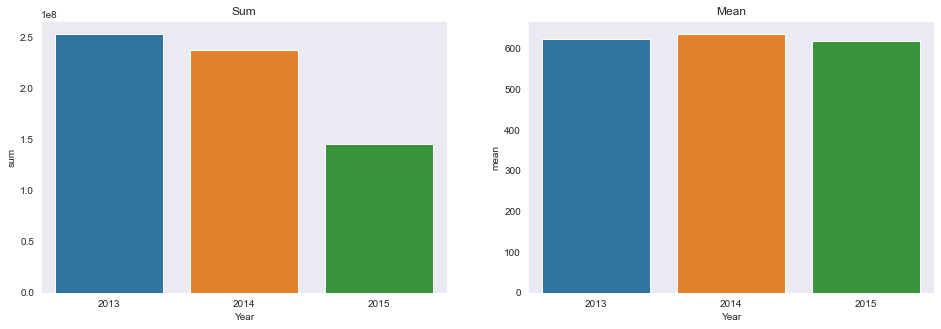

In [35]:
# Customers and Year variable 

groupby_var('Customers', 'Year')

##### SalePerCust

min   max        sum  mean
DayOfWeek                            
1          0.0  15.0  1357815.0   9.0
2          0.0  15.0  1378844.0   9.0
3          0.0  15.0  1346265.0   9.0
4          0.0  15.0  1258764.0   9.0
5          0.0  15.0  1307317.0   9.0
6          0.0  15.0  1333268.0   9.0
7          0.0  13.0    23209.0   0.0

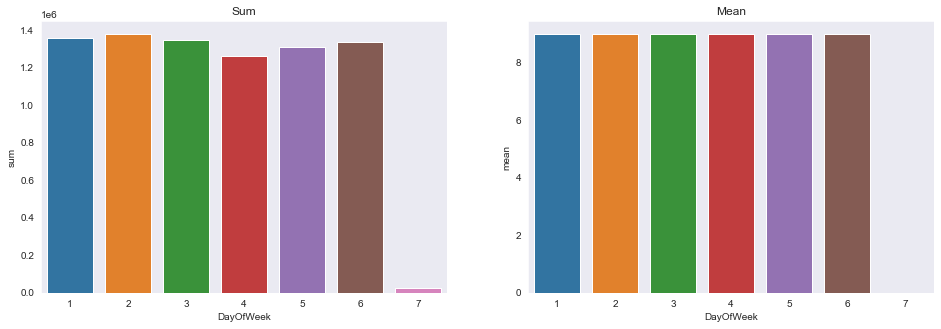

In [36]:
# SalePerCust and DayOfWeek variable 

groupby_var('SalePerCust', 'DayOfWeek')

min   max       sum  mean
Month                           
1      0.0  15.0  814868.0   8.0
2      0.0  15.0  752638.0   8.0
3      0.0  15.0  820418.0   8.0
4      0.0  15.0  773133.0   8.0
5      0.0  15.0  763330.0   7.0
6      0.0  15.0  791232.0   8.0
7      0.0  15.0  823695.0   8.0
8      0.0  15.0  502815.0   8.0
9      0.0  15.0  477158.0   8.0
10     0.0  15.0  488318.0   8.0
11     0.0  15.0  492741.0   8.0
12     0.0  15.0  505134.0   8.0

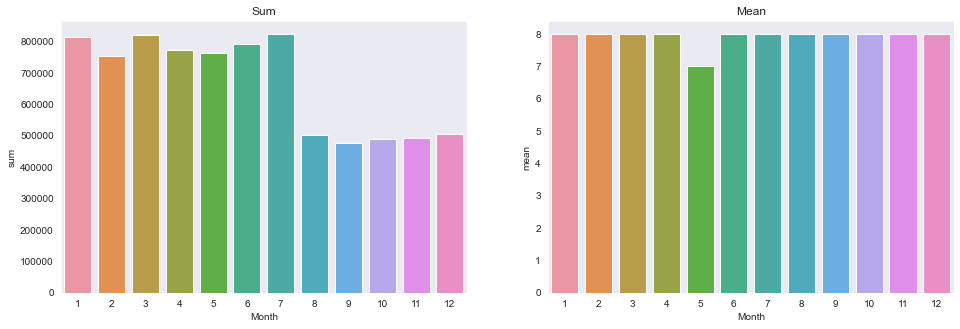

In [37]:
# SalePerCust and Month variable 

groupby_var('SalePerCust', 'Month')

min   max        sum  mean
Year                            
2013  0.0  15.0  3161530.0   8.0
2014  0.0  15.0  2924518.0   8.0
2015  0.0  15.0  1919434.0   8.0

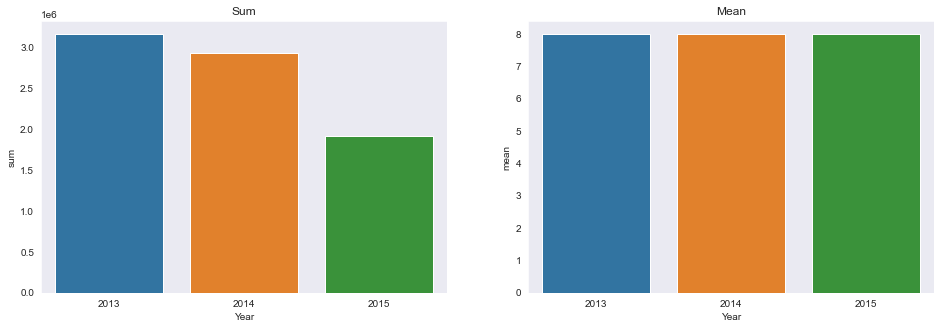

In [38]:
# SalePerCust and Year variable 

groupby_var('SalePerCust', 'Year')

#### Sales and Customer variation in each categorical variable

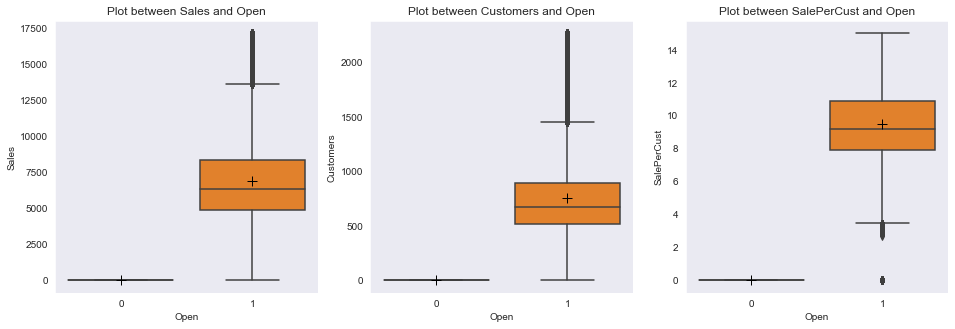

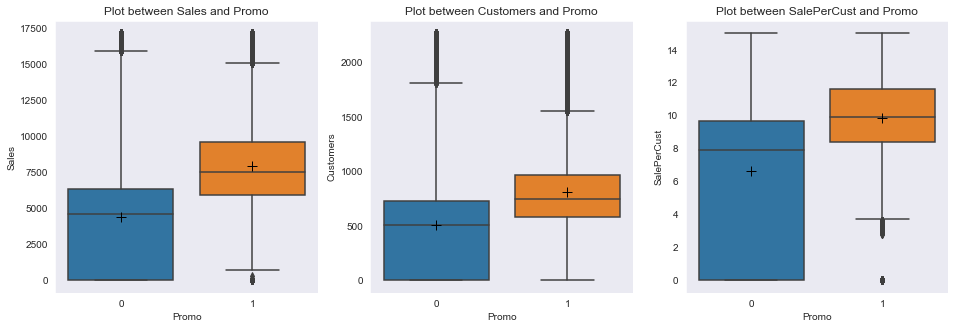

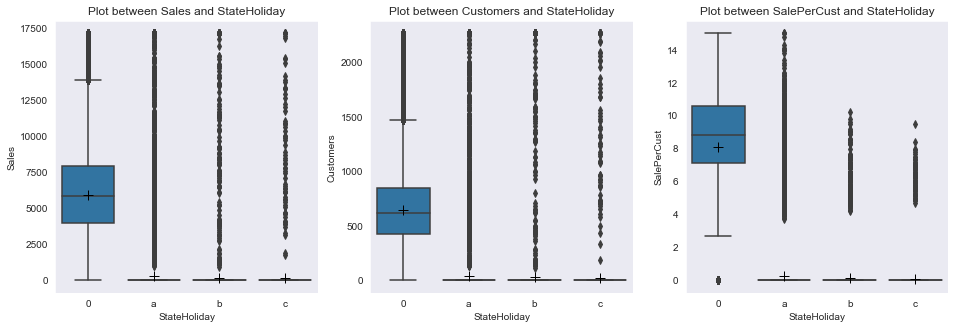

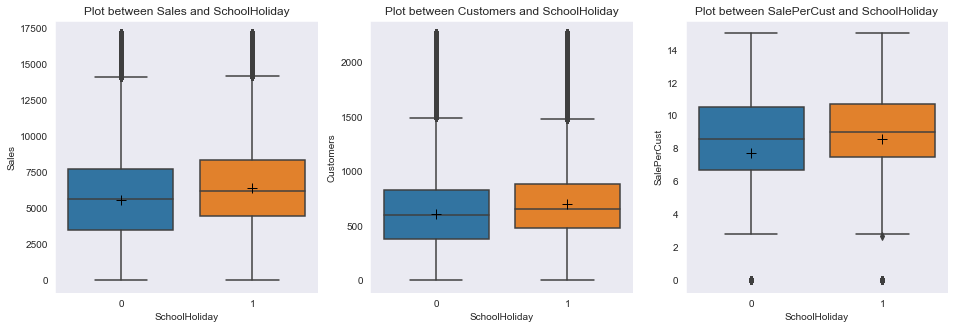

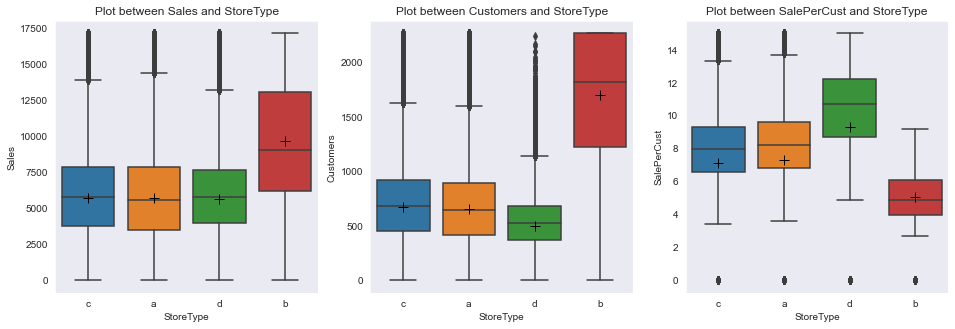

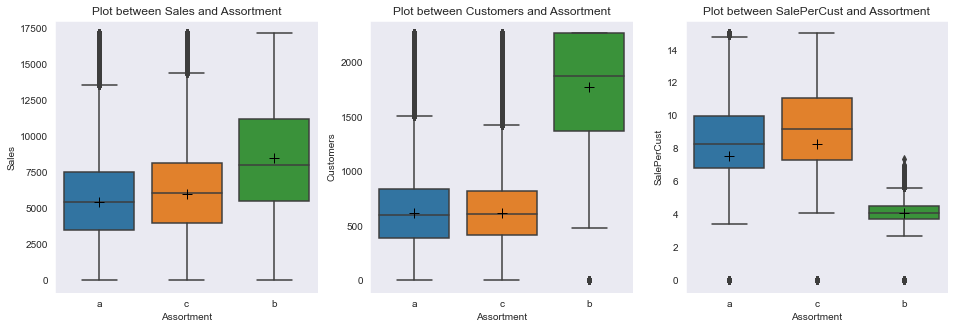

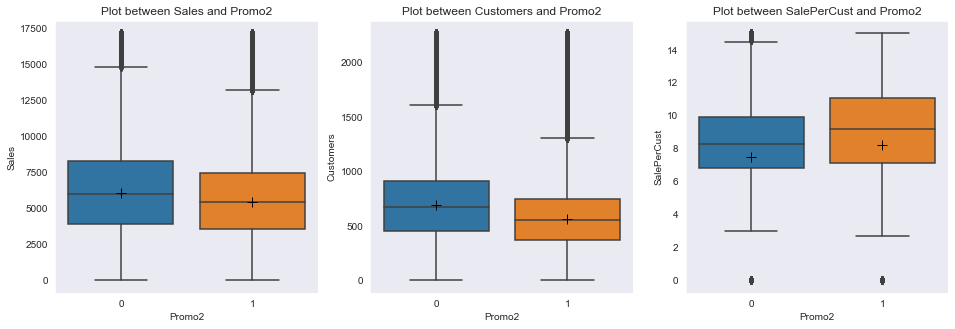

In [39]:
# box plot between following variables wrt sales, customers and salespercustomer
lx = ['Open','Promo','StateHoliday','SchoolHoliday','StoreType','Assortment', 'Promo2']

for i in lx:
    fig = plt.figure(figsize = (16,5))
    plt.subplot(1,3,1)
    plt.title('Plot between Sales and '+i)
    sns.boxplot(data = mdata, y = 'Sales', x = i, showmeans = True, meanprops={"marker": "+", "markeredgecolor": "black", "markersize": "10"})
    plt.subplot(1,3,2)
    plt.title('Plot between Customers and '+i)
    sns.boxplot(data = mdata, y = 'Customers', x = i, showmeans = True, meanprops={"marker": "+", "markeredgecolor": "black", "markersize": "10"})
    plt.subplot(1,3,3)
    plt.title('Plot between SalePerCust and '+i)
    sns.boxplot(data = mdata, y = 'SalePerCust', x = i, showmeans = True, meanprops={"marker": "+", "markeredgecolor": "black", "markersize": "10"})

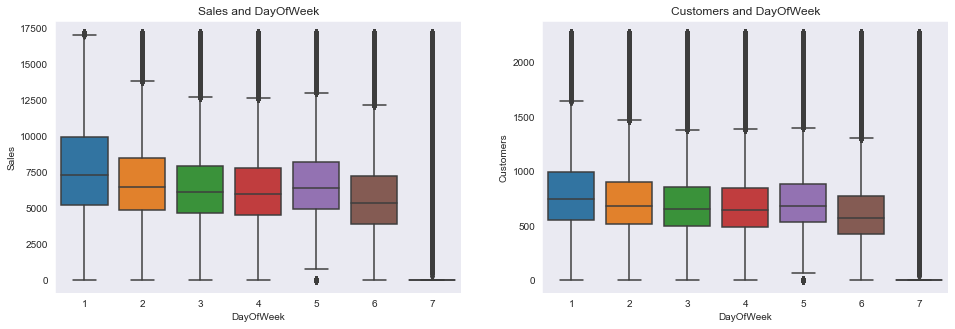

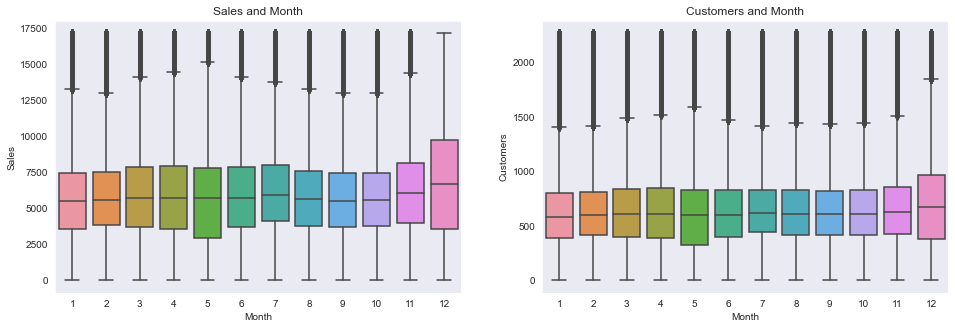

In [40]:
# temporal variation in sales and customer visits
lx = ['DayOfWeek' ,'Month']

for i in lx:
    fig = plt.figure(figsize = (16,5))
    plt.subplot(1,2,1)
    plt.title('Sales and '+ i)
    sns.boxplot(data = mdata, y = 'Sales', x = i)
    plt.subplot(1,2,2)
    plt.title('Customers and '+ i)
    sns.boxplot(data = mdata, y = 'Customers', x = i)

#### Sales and Customer relationships

<AxesSubplot:xlabel='Sales', ylabel='Customers'>

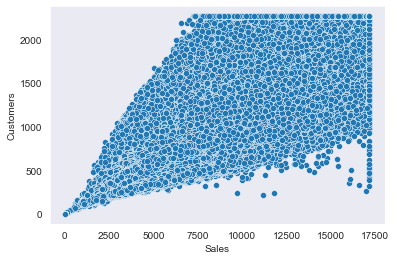

In [41]:
# scatter plot between Sales and Customers

sns.scatterplot(data = mdata, x = 'Sales', y = 'Customers')

<AxesSubplot:xlabel='CompetitionDistance', ylabel='SalePerCust'>

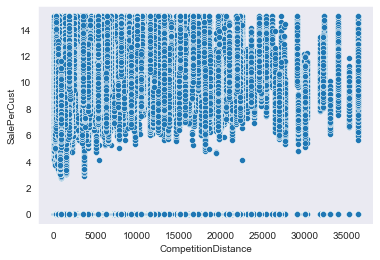

In [42]:
# scatterplot between Salespercustomer and competitionDistance

sns.scatterplot(data = mdata, y = 'SalePerCust', x = 'CompetitionDistance')

#### Correlation among all variables

<AxesSubplot:>

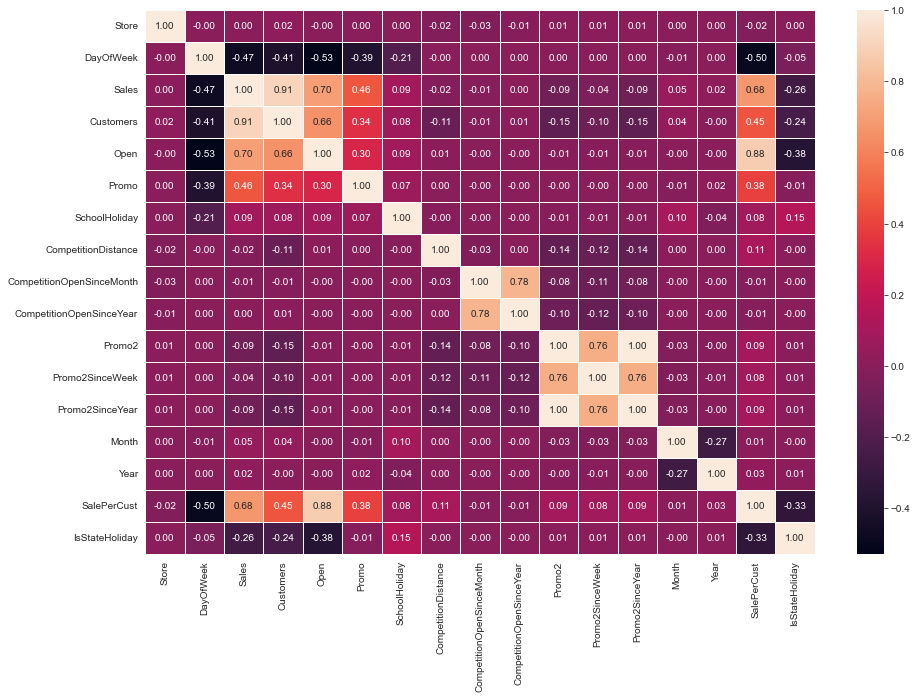

In [43]:
# correlation between all variables

plt.figure(figsize = (15,10))
sns.heatmap(mdata.corr(),annot=True, fmt=".2f", linewidth=.5)

In [44]:
# Checking correlation between Sales and other variable

mdata.corr()['Sales'].sort_values()

DayOfWeek                   -0.472055
IsStateHoliday              -0.261402
Promo2SinceYear             -0.088433
Promo2                      -0.088417
Promo2SinceWeek             -0.041797
CompetitionDistance         -0.018227
CompetitionOpenSinceMonth   -0.011209
CompetitionOpenSinceYear     0.003055
Store                        0.004129
Year                         0.024729
Month                        0.047552
SchoolHoliday                0.086904
Promo                        0.460764
SalePerCust                  0.676960
Open                         0.695950
Customers                    0.908508
Sales                        1.000000
Name: Sales, dtype: float64

In [45]:
# Sunbrust plot for 'Promo', 'StoreType', 'Assortment' and 'Sales'

fig = px.sunburst(mdata, 
                  title= "Sunbrust plot for Promo, Storetype and Assortment", 
                  path=['Promo', 'StoreType', 'Assortment'], 
                  values='Sales')
fig.show()

**Inference**

- The average sales for all all store in maximum during the Monday(1) and decreases steadily till thursday, also lowerst on sunday.
- Sales during first 7 month of the year is maximum, after july month the sales starts to decrease till december.
- Maximum customer has visited during the Mondays, and then decreases till thursday.
- The customer patten follows the sales pattern for week and month. 
- It is observed that the Promo is affecting the total sales from all stores. The mean value of sales for promotion is more than normal sales. 
- The sales per customer for promo is about 10 and for normal its around 8. 
- Sales and citomer visits is not affected by the SchoolHolidays.
- There are overall 4 store types in dataset, outof which store b have maximum sales and customer visit. But store a, b, c have higher sales per customer as compared to b. 
- The extra Assortment shows maximum sales and customer visits as compared to basic and extended, but for the salespercustomer the siatuation is vice versa.
- The scatterplot between sales and customer shows increasing trend with the correlation of 0.90.
- Sales is associated with the promo shows the correlation of 0.46.

# 6. Data Preperation for modeling

In [46]:
# taking out the data for the 1,3,8,9,13,25,29,31 and 46 stores

slist = [1,3,8,9,13,25,29,31,46]

# taking dataset from above list
sdata = mdata.loc[mdata['Store'].isin(slist), :]

# setting index
sdata = sdata.set_index('Date')

In [47]:
# plotting time series forecasting plot 

#for i in sdata.Store.unique():
#    plt.figure(figsize = (20,5))
#    plt.title('time series plot for {} store'.format(i) )
#    plt.plot(sdata[sdata['Store'] == i].Sales)

#### Aggregating variables

In [48]:
# Grouping the data at a date level for analysis

fdf=sdata.groupby('Date').agg({'Sales': 'mean', 
                               'Customers':'mean',
                               'Open': 'sum',
                               'Promo' : 'sum',
                               'IsStateHoliday' : 'sum'
                              }).round()

In [49]:
# Converting all categorical variables into 0 and 1

fdf['Open'] = fdf['Open'].apply(lambda x: 1 if x >0 else 0)
fdf['Promo'] = fdf['Promo'].apply(lambda x: 1 if x >0 else 0)
fdf['IsStateHoliday'] = fdf['IsStateHoliday'].apply(lambda x: 1 if x >0 else 0)

In [50]:
fdf.describe()

Sales    Customers        Open       Promo  IsStateHoliday
count    942.000000   942.000000  942.000000  942.000000      942.000000
mean    5412.079618   592.722930    0.832272    0.382166        0.035032
std     2856.797879   291.038294    0.373823    0.486175        0.183958
min        0.000000     0.000000    0.000000    0.000000        0.000000
25%     4794.000000   580.500000    1.000000    0.000000        0.000000
50%     5679.500000   663.500000    1.000000    0.000000        0.000000
75%     7212.750000   763.750000    1.000000    1.000000        0.000000
max    12505.000000  1238.000000    1.000000    1.000000        1.000000

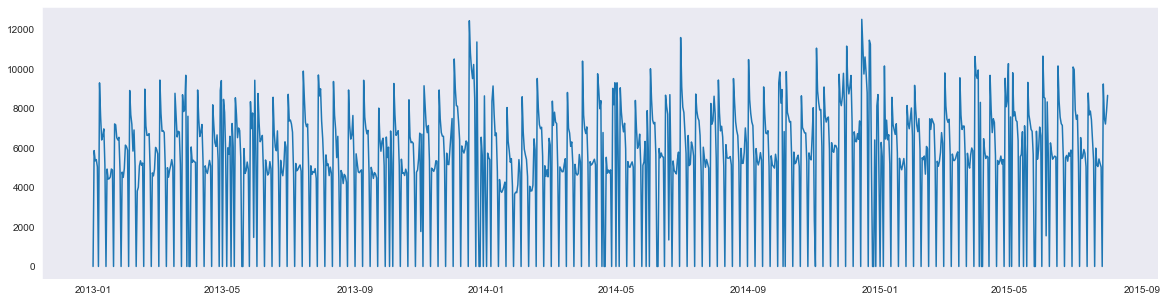

In [51]:
plt.figure(figsize = (20,5))
plt.plot(fdf.Sales)

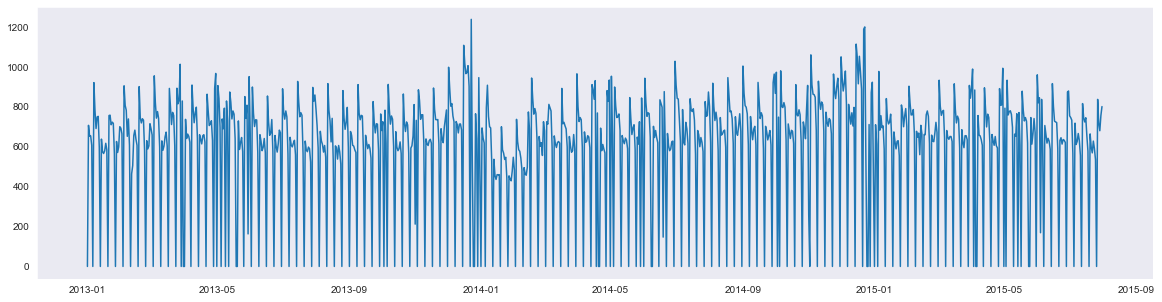

In [52]:
plt.figure(figsize = (20,5))
plt.plot(fdf.Customers)

#### Sales Variable Decomposition

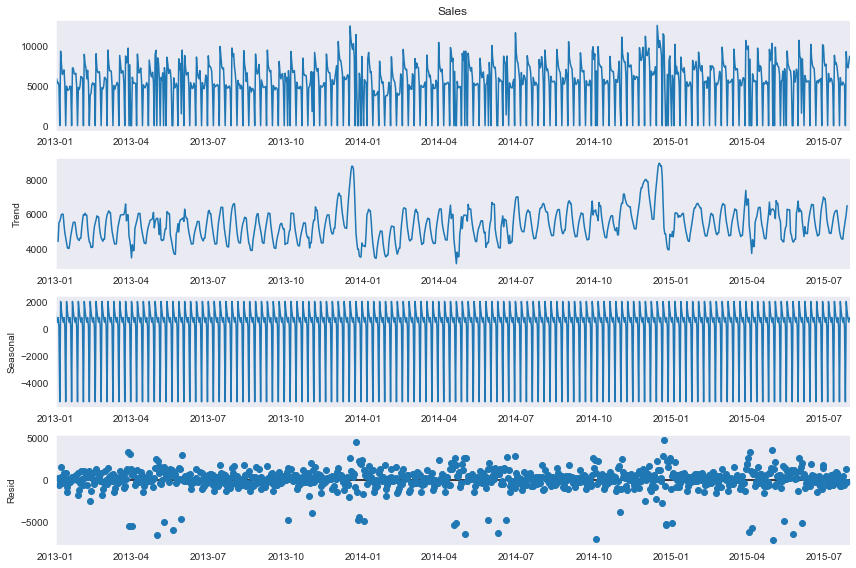

In [53]:
# sales decomposition
rcParams['figure.figsize'] = 12,8
decompo = sm.tsa.seasonal_decompose(fdf.Sales, model = 'additive') # Multiplicative 
fig = decompo.plot()

#### Autocorrelation 

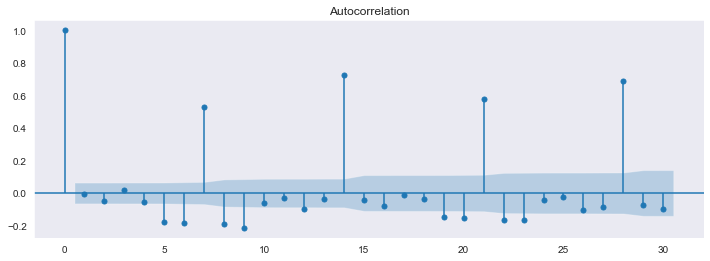

In [54]:
# Autocorrelation function for Sales
plt.figure(figsize = (12,4))
plot_acf(fdf['Sales'],ax = plt.gca(), lags = 30)
plt.show()

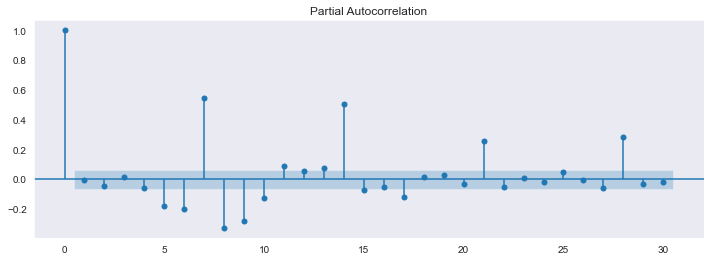

In [55]:
# Partial Autocorrelation function for Sales
plt.figure(figsize = (12,4))
plot_pacf(fdf['Sales'],ax = plt.gca(), lags = 30)
plt.show()

- 

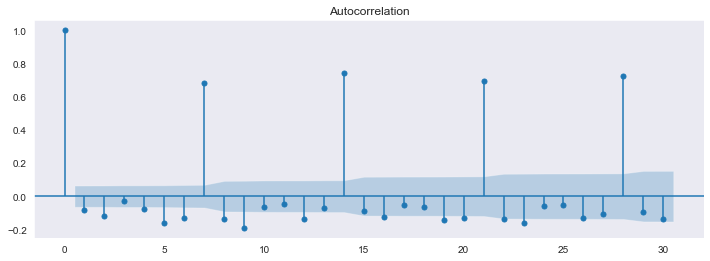

In [56]:
# Autocorrelation function for Sales
plt.figure(figsize = (12,4))
plot_acf(fdf['Customers'],ax = plt.gca(), lags = 30)
plt.show()

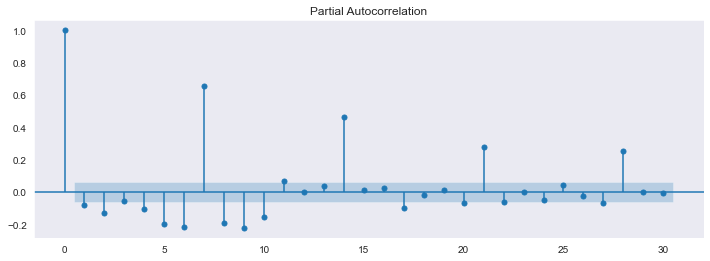

In [57]:
# Partial Autocorrelation function for Sales
plt.figure(figsize = (12,4))
plot_pacf(fdf['Customers'],ax = plt.gca(), lags = 30)
plt.show()

#### Check for stationarity

In [58]:
# Checking for stationarity check for Sales column
adf_test = adfuller(fdf['Sales'])
print(adf_test)
print('ADF stats', adf_test[0].round(2))
print('P-value', adf_test[1].round(2))

(-4.62465098511533, 0.00011630971518486851, 21, 920, {'1%': -3.4374778690219956, '5%': -2.864686684217556, '10%': -2.5684454926748583}, 16314.632768358699)
ADF stats -4.62
P-value 0.0


- Here the p value is less than 0.05 which indicates that the given series is `stationary`

In [59]:
# Checking for stationarity check for Customers column
adf_test = adfuller(fdf['Customers'])
print(adf_test)
print('ADF stats', adf_test[0].round(2))
print('P-value', adf_test[1].round(2))

(-4.314540571305967, 0.0004191507458879535, 21, 920, {'1%': -3.4374778690219956, '5%': -2.864686684217556, '10%': -2.5684454926748583}, 12035.545558050528)
ADF stats -4.31
P-value 0.0


- Here the p value is less than 0.05 which indicates that the given series is `Stationary`

In [60]:
fdf.head()

Sales  Customers  Open  Promo  IsStateHoliday
Date                                                      
2013-01-01     0.0        0.0     0      0               1
2013-01-02  5863.0      707.0     1      0               0
2013-01-03  5346.0      653.0     1      0               0
2013-01-04  5407.0      654.0     1      0               0
2013-01-05  5045.0      607.0     1      0               0

#### Standardization 

In [61]:
# implementing minmaxscaler
scaler = MinMaxScaler()

fdf[['Sales', 'Customers']] = scaler.fit_transform(fdf[['Sales', 'Customers']])

fdf.head()

Sales  Customers  Open  Promo  IsStateHoliday
Date                                                        
2013-01-01  0.000000   0.000000     0      0               1
2013-01-02  0.468852   0.571082     1      0               0
2013-01-03  0.427509   0.527464     1      0               0
2013-01-04  0.432387   0.528271     1      0               0
2013-01-05  0.403439   0.490307     1      0               0

#### Train Test Split

In [62]:
# final dataset shape
fdf.shape

(942, 5)

In [63]:
# We need to predict for next 6 weeks and we are having daily data

total_weeks = 6

total_days = total_weeks * 7

train = fdf[:len(fdf) - total_days]
test = fdf[len(fdf) - total_days:]

In [64]:
train.shape, test.shape

((900, 5), (42, 5))

# 7. Modeling

##  `Vector Autoregressive (VAR) Model`

In [65]:
# Train and test data set for VAR model

var_train = train[['Sales', 'Customers']]
var_test = test[['Sales', 'Customers']]

In [66]:
# applying var model
var_model = VAR(var_train)

In [67]:
# Checking for 15 lag values
ab = var_model.select_order(15)
print(ab.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -9.175      -9.164   0.0001036      -9.171
1       -9.779      -9.746   5.664e-05      -9.766
2       -9.820      -9.766   5.435e-05      -9.799
3       -9.901      -9.826   5.010e-05      -9.872
4       -9.924      -9.827   4.899e-05      -9.887
5       -10.06      -9.938   4.288e-05      -10.01
6       -10.18      -10.04   3.802e-05      -10.12
7       -10.97      -10.81   1.713e-05      -10.91
8       -11.09      -10.90   1.532e-05      -11.02
9       -11.11      -10.90   1.500e-05      -11.03
10      -11.10      -10.88   1.506e-05      -11.02
11      -11.11      -10.86   1.500e-05      -11.01
12      -11.12      -10.85   1.487e-05      -11.01
13      -11.13      -10.84   1.464e-05      -11.02
14      -11.27      -10.95   1.280e-05      -11.15
15     -11.30*     -10.96*  1.238e-05*     -11.17*
-------------------------------

In [68]:
# taking best lag value
res = var_model.fit(maxlags=15)

# printing the summary
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 12, Apr, 2023
Time:                     11:09:12
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -10.9639
Nobs:                     885.000    HQIC:                  -11.1710
Log likelihood:           2550.37    FPE:                1.23838e-05
AIC:                     -11.2992    Det(Omega_mle):     1.15598e-05
--------------------------------------------------------------------
Results for equation Sales
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.243799         0.050695            4.809           0.000
L1.Sales              1.386318         0.166183            8.342           0.000
L1.Customers         -1.398138         0.160405           -8

In [69]:
# res.plot()

Figure(720x720)


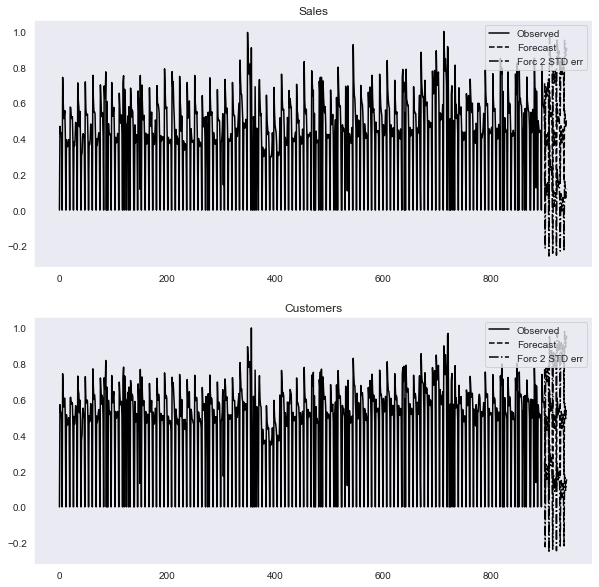

In [70]:
print(res.plot_forecast(len(var_test)));

In [71]:
# Get the lag order
lag_order = res.k_ar
print(lag_order)

15


In [72]:
# forecasting for next 42 values
forecast_value = res.forecast(var_train.values[:],
                              steps = len(var_test)) #42

# Creating dataframe
pred = (pd.DataFrame(forecast_value, 
                     index=test.index, 
                     columns= ['Sales_pred', 'Customers_pred']))
pred.head(2)

Sales_pred  Customers_pred
Date                                  
2015-06-20    0.460202        0.510713
2015-06-21    0.047588        0.041259

In [73]:
# merging two dataframes
var_test['Sales_fore'] = pred.Sales_pred
var_test['Customer_fore'] = pred.Customers_pred

In [74]:
# function for plot
def forecasted_timeseries_visualization(series,forecasted_series):
    fig = plt.figure(figsize=(20, 3))
    series.plot(label='Actual')
    forecasted_series.plot(label='Forecasted')
    plt.xlabel('Date')
    plt.legend(loc='best')
    plt.show()

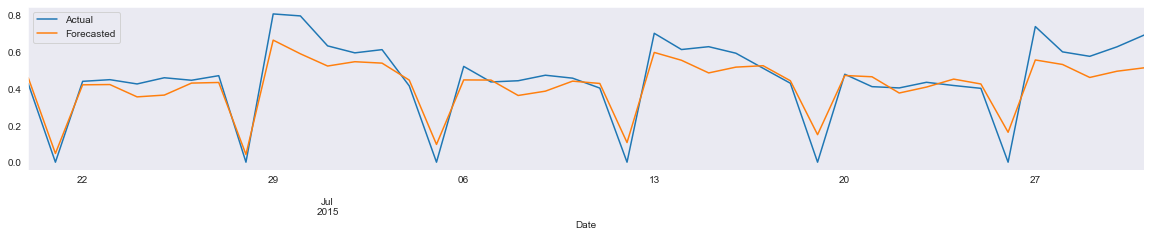

In [75]:
# plot between actual and forecasted sales

forecasted_timeseries_visualization(var_test['Sales'],var_test['Sales_fore'] )

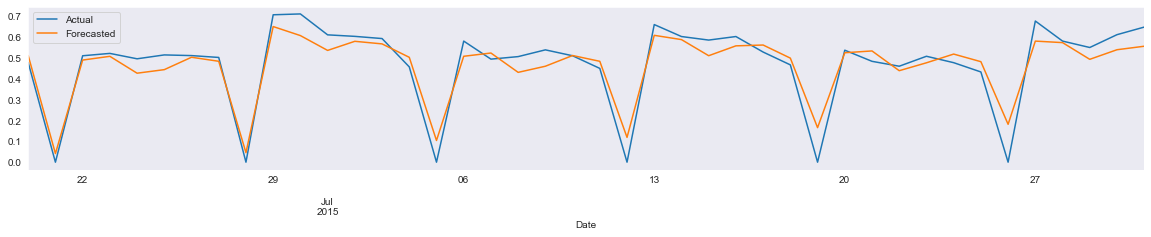

In [76]:
# plot between Customers and forecasted Customers

forecasted_timeseries_visualization(var_test['Customers'],var_test['Customer_fore'] )

#### Evaluation Matrix

In [77]:
# evaluation matrix
summary_df = pd.DataFrame(columns=['Model','variable', 'MSE', 'RMSE','MAPE'])

def eval_matrix(Model, Variable, y_true_value, y_pred_value):
    mape = mean_absolute_percentage_error(y_true = y_true_value, y_pred = y_pred_value).round(4)
    mse = mean_squared_error(y_true = y_true_value, y_pred = y_pred_value).round(4)
    rmse = np.sqrt(mse).round(4)
    d = pd.DataFrame({'Model': [Model],'variable': [Variable], 
                         'MSE':[mse], 'RMSE':[rmse],'MAPE':[mape]})
    return d

In [78]:
'''Taking only non-zero values, 
is we keep the zeros then the value of MAPE is way too high'''

without_zero = var_test[var_test['Sales'] != 0]

In [79]:
# final dataframe
a1 = eval_matrix('Var', 'Sales', without_zero['Sales'], without_zero['Sales_fore'])
a2 = eval_matrix('Var', 'Customers', without_zero['Customers'], without_zero['Customer_fore'])


summary_df = pd.concat([summary_df, a1, a2])
summary_df

Model   variable     MSE    RMSE    MAPE
0   Var      Sales  0.0075  0.0866  0.1188
0   Var  Customers  0.0028  0.0529  0.0818

In [80]:
# Looking at day wise accuracy

comb = without_zero.copy()
comb['accuracy_sales'] = round(comb.apply(lambda row: row.Sales_fore / row.Sales *100, axis = 1),2)
comb['accuracy_sales'] = pd.Series(["{0:.2f}%".format(val) for val in comb['accuracy_sales']],index = comb.index)
comb = comb.assign(day_of_week = lambda x: x.index.day_name())
comb = comb.round(decimals=2)
comb = comb.reset_index()
comb.head()

Date  Sales  Customers  Sales_fore  Customer_fore accuracy_sales  \
0 2015-06-20   0.43       0.48        0.46           0.51        107.47%   
1 2015-06-22   0.44       0.51        0.42           0.49         95.70%   
2 2015-06-23   0.45       0.52        0.42           0.51         94.10%   
3 2015-06-24   0.43       0.50        0.36           0.43         83.48%   
4 2015-06-25   0.46       0.51        0.37           0.44         79.46%   

  day_of_week  
0    Saturday  
1      Monday  
2     Tuesday  
3   Wednesday  
4    Thursday

## `vector autoregressive moving-average processes with exogenous regressors (VARMAX) models`

#### Johansen Test

In [81]:
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [82]:
joh_model1 = coint_johansen(fdf[['Sales', 'Customers']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    121.594999  155.338825
1     33.743826   33.743826 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [83]:
# Train and test data set for VAR model

varmax_train = train[['Sales', 'Customers']]
varmax_test = test[['Sales', 'Customers']]

In [84]:
#modelling

exog = train[['Open','Promo','IsStateHoliday']].astype(float)
endog = train[['Sales', 'Customers']].astype(float)


varmax_model = sm.tsa.VARMAX(endog, order=(7,7),  exog=exog)
varmax_model_fit = varmax_model.fit(maxiter=1000, disp=False)
print(varmax_model_fit.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  900
Model:                        VARMAX(7,7)   Log Likelihood                3413.239
                              + intercept   AIC                          -6692.479
Date:                    Wed, 12 Apr 2023   BIC                          -6370.718
Time:                            11:13:52   HQIC                         -6569.564
Sample:                        01-01-2013                                         
                             - 06-19-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            9.75, 16.01   Jarque-Bera (JB):     1151.86, 1001.58
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.47, 1.24   Skew:                      0.31, -1.09
P

In [85]:
#forecasting on test data
exog_test = test[['Open','Promo','IsStateHoliday']].astype(float)
endog_test= test[['Sales','Customers']]

varmax_fc = varmax_model_fit.predict(start=varmax_test.index.min(),end=varmax_test.index.max(),exog=exog_test)

varmax_forecast = pd.DataFrame(varmax_fc, index=varmax_test.index, columns=['Sales','Customers'])

varmax_forecast.head()

Sales  Customers
Date                           
2015-06-20  0.423585   0.484205
2015-06-21 -0.046833  -0.053818
2015-06-22  0.498673   0.573638
2015-06-23  0.402836   0.494729
2015-06-24  0.387470   0.475413

In [86]:
# merging two dataframes
varmax_test['Sales_fore_varmax'] = varmax_forecast.Sales
varmax_test['Customer_fore_varmax'] = varmax_forecast.Customers

In [87]:
varmax_test.head()

Sales  Customers  Sales_fore_varmax  Customer_fore_varmax
Date                                                                    
2015-06-20  0.428229   0.477383           0.423585              0.484205
2015-06-21  0.000000   0.000000          -0.046833             -0.053818
2015-06-22  0.440224   0.509693           0.498673              0.573638
2015-06-23  0.449260   0.521002           0.402836              0.494729
2015-06-24  0.425990   0.495153           0.387470              0.475413

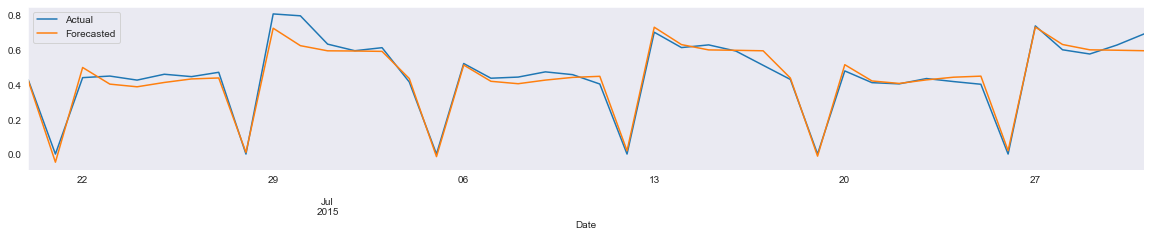

In [88]:
# plot between actual and forecasted sales

forecasted_timeseries_visualization(varmax_test['Sales'],varmax_test['Sales_fore_varmax'] )

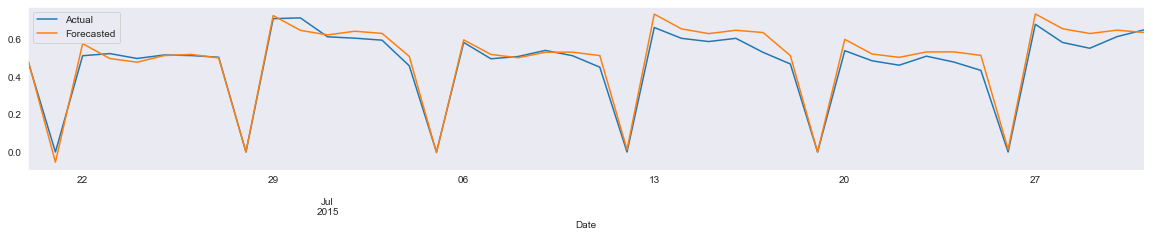

In [89]:
# plot between actual and forecasted sales

forecasted_timeseries_visualization(varmax_test['Customers'],varmax_test['Customer_fore_varmax'] )

#### Evaluation Matrix

In [90]:
'''Taking only non-zero values, is we keep the zeros then the value of MAPE is way too high'''

without_zero_varmax = varmax_test[varmax_test['Sales'] != 0]

In [91]:
# final dataframe
b1 = eval_matrix('Varmax', 'Sales', without_zero_varmax['Sales'], without_zero_varmax['Sales_fore_varmax'])
b2 = eval_matrix('Varmax', 'Customers', without_zero_varmax['Customers'], without_zero_varmax['Customer_fore_varmax'])

summary_df = pd.concat([summary_df, b1, b2])
summary_df

Model   variable     MSE    RMSE    MAPE
0     Var      Sales  0.0075  0.0866  0.1188
0     Var  Customers  0.0028  0.0529  0.0818
0  Varmax      Sales  0.0022  0.0469  0.0635
0  Varmax  Customers  0.0021  0.0458  0.0713

In [92]:
# Looking at day wise accuracy

combv = without_zero_varmax.copy()
combv['accuracy_sales'] = round(combv.apply(lambda row: row.Sales_fore_varmax / row.Sales *100, axis = 1),2)
combv['accuracy_sales'] = pd.Series(["{0:.2f}%".format(val) for val in combv['accuracy_sales']], index = combv.index)
combv = combv.assign(day_of_week = lambda x: x.index.day_name())
combv = combv.round(decimals=2)
combv = combv.reset_index()
combv.head()

Date  Sales  Customers  Sales_fore_varmax  Customer_fore_varmax  \
0 2015-06-20   0.43       0.48               0.42                  0.48   
1 2015-06-22   0.44       0.51               0.50                  0.57   
2 2015-06-23   0.45       0.52               0.40                  0.49   
3 2015-06-24   0.43       0.50               0.39                  0.48   
4 2015-06-25   0.46       0.51               0.41                  0.51   

  accuracy_sales day_of_week  
0         98.92%    Saturday  
1        113.28%      Monday  
2         89.67%     Tuesday  
3         90.96%   Wednesday  
4         89.71%    Thursday

In [93]:
summary_df

Model   variable     MSE    RMSE    MAPE
0     Var      Sales  0.0075  0.0866  0.1188
0     Var  Customers  0.0028  0.0529  0.0818
0  Varmax      Sales  0.0022  0.0469  0.0635
0  Varmax  Customers  0.0021  0.0458  0.0713